# Step #1 Make Imports and Check Training Device

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

tf.config.allow_growth = True
tf.config.per_process_gpu_memory_fraction = 0.9

from random import randint
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import random as rdn

In [2]:
# check the tensorflow version
print('Tensorflow Version: ' + tf.__version__)

# check the number of available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.4.0-rc3
Num GPUs: 1


# Step #2 Define the Prediction Classes

In [3]:
# set the directory for train and validation images
train_path = 'data/cats-and-dogs/train/'
test_path = 'data/cats-and-dogs/test/'

# function to create a list of image labels 
def createImageDf(path):
    filenames = os.listdir(path)
    categories = []

    for fname in filenames:
        category = fname.split('.')[0]
        if category == 'dog':
            categories.append(1)
        else:
            categories.append(0)
    df = pd.DataFrame({
        'filename':filenames,
        'category':categories
    })
    return df

# display the header of the train_df dataset
image_df = createImageDf(train_path)
image_df.head(5)

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


<BarContainer object of 2 artists>

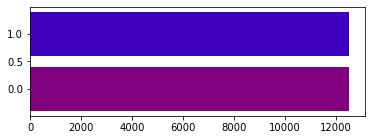

In [4]:
# Print the number of images in each class
clist = [(0, "purple"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
x = np.arange(0, len(["dog","cat"]))
y = image_df['category'].value_counts()
N = y.size

fig, ax = plt.subplots(figsize=(6, 2))
ax.barh(x, y, color=rvb(x/N))

# Step #3 Plot Sample Images

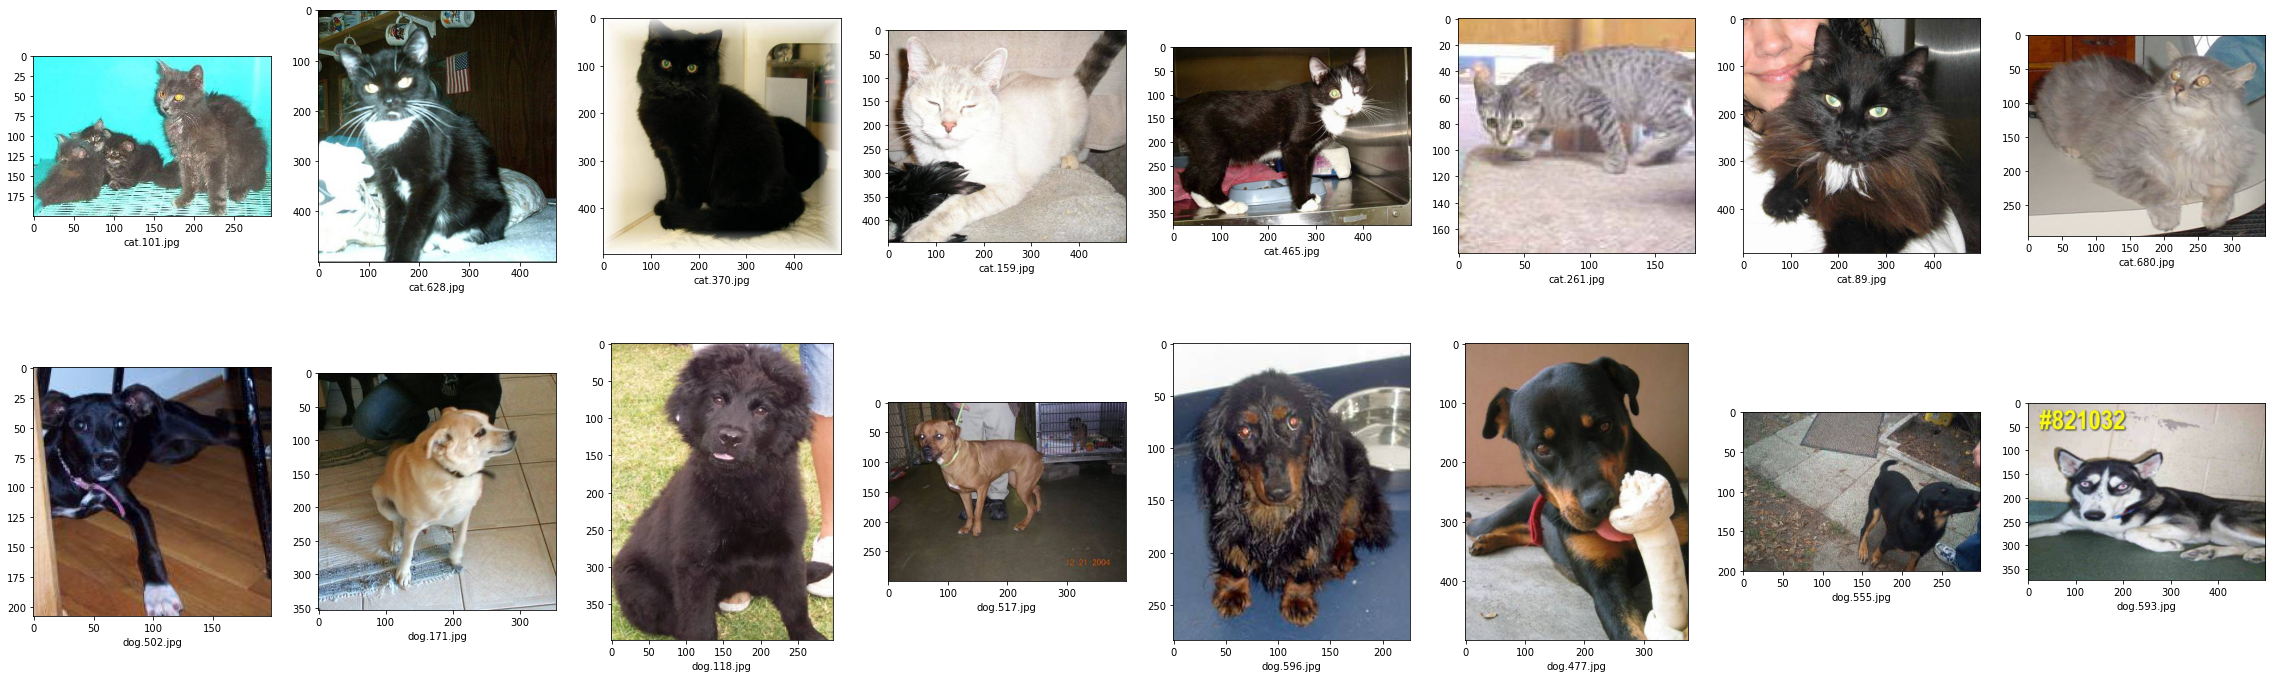

In [5]:
n_pictures = 16 # number of pictures to be shown
columns = int(n_pictures / 2)
rows = 2
plt.figure(figsize=(40, 12))
for i in range(n_pictures):
    num = i + 1
    ax = plt.subplot(rows, columns, i + 1)
    if i < columns:
        image_name = 'cat.' + str(rdn.randint(1, 1000)) + '.jpg'
    else: 
        image_name = 'dog.' + str(rdn.randint(1, 1000)) + '.jpg'
    plt.xlabel(image_name)    
    plt.imshow(load_img(train_path + image_name)) 

#if you get a deprecated warning, you can ignore it

# Step #4 Split the Data

In [6]:
image_df["category"] = image_df["category"].replace({0:'cat',1:'dog'})

train_df, validate_df = train_test_split(image_df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
total_train = train_df.shape[0]

validate_df = validate_df.reset_index(drop=True)
total_validate = validate_df.shape[0]
train_df.head()
print(len(train_df), len(validate_df))

20000 5000


In [7]:
validate_df

,filename,category
0,cat.493.jpg,cat
1,dog.9112.jpg,dog
2,cat.745.jpg,cat
3,dog.11022.jpg,dog
4,dog.11363.jpg,dog
...,...,...
4995,cat.6551.jpg,cat
4996,cat.9403.jpg,cat
4997,cat.236.jpg,cat
4998,dog.6530.jpg,dog


# Step #5 Preprocess the Images

In [8]:
# set the dimensions to which we will convert the images
img_width, img_height = 128, 128
target_size = (img_width, img_height)
batch_size = 32
rescale=1.0/255

# configure the train data generator
print('Train data:')
train_datagen = ImageDataGenerator(rescale=rescale)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path,
    shear_range=0.2, #stretches the image
    zoom_range=0.2, #random zoom into the picture
    horizontal_flip=True, # flip the image horizontally
    shuffle=True, # shuffle the image data
    x_col='filename', y_col='category',
    classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='binary')

# configure test data generator
# only rescaling
print('Test data:')
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_path,    
    x_col='filename', y_col='category',
    classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False, 
    color_mode="rgb",
    class_mode='binary')

Train data:
Found 20000 validated image filenames belonging to 2 classes.
Test data:
Found 5000 validated image filenames belonging to 2 classes.


# Step #6 Define and Compile the Convolutional Neural Network

In [9]:
# define the input format of the model
input_shape = (img_width, img_height, 3)
print("input_shape: " + str(input_shape))

# define  model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(128, (3, 3),  strides=(1, 1),activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model and print its architecture
opt = SGD(lr=0.001, momentum=0.9)
history = model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

input_shape: (128, 128, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            

# Step #7 Train the Convolutional Neural Network

In [10]:
# train the model
epochs = 35
early_stop = EarlyStopping(monitor='loss', patience=6, verbose=1)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stop],
    steps_per_epoch=len(train_generator),
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/35
625/625 [==============================] - 57s 83ms/step - loss: 0.7674 - accuracy: 0.5140 - val_loss: 0.6911 - val_accuracy: 0.5074
Epoch 2/35
625/625 [==============================] - 45s 72ms/step - loss: 0.6844 - accuracy: 0.5565 - val_loss: 0.6889 - val_accuracy: 0.5252
Epoch 3/35
625/625 [==============================] - 47s 76ms/step - loss: 0.6651 - accuracy: 0.5849 - val_loss: 0.6643 - val_accuracy: 0.5906
Epoch 4/35
625/625 [==============================] - 50s 79ms/step - loss: 0.6482 - accuracy: 0.6035 - val_loss: 0.6359 - val_accuracy: 0.6320
Epoch 5/35
625/625 [==============================] - 52s 83ms/step - loss: 0.6210 - accuracy: 0.6412 - val_loss: 0.6173 - val_accuracy: 0.6654
Epoch 6/35
625/625 [==============================] - 56s 90ms/step - loss: 0.5993 - accuracy: 0.6745 - val_loss: 0.6128 - val_accuracy: 0.6430
Epoch 7/35
625/625 [==============================] - 57s 91ms/step - loss: 0.5878 - accuracy: 0.6863 - val_loss: 0.5845 - val_accuracy:

In [15]:
# Safe the weights
model.save_weights('cats-and-dogs-weights-v1.h5')

# Define model as during training
# model architecture

# Loads the weights
# model.load_weights('cats-and-dogs-weights-v1.h5')

# Step #8 Visualize Model Performance

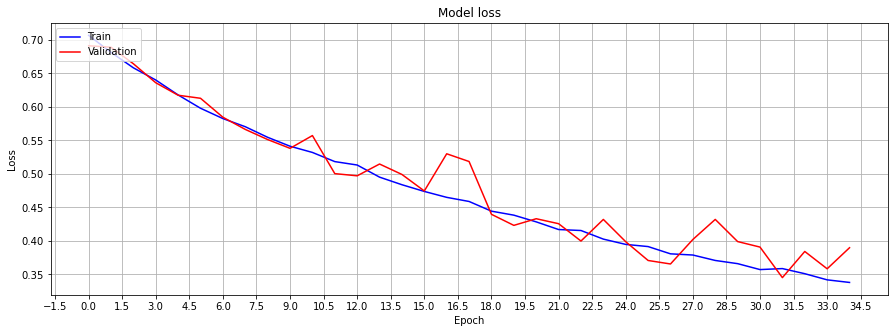

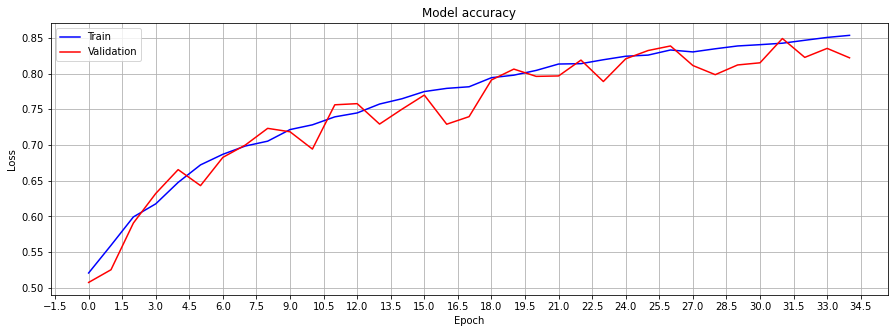

In [16]:
# plot training & validation loss values
fig, ax = plt.subplots(figsize=(15, 5), sharex=True)
plt.plot(history.history["loss"], 'b')
plt.plot(history.history["val_loss"], 'r')
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Validation"], loc="upper left")
plt.grid()
plt.show()

# plot training & validation loss values
fig, ax = plt.subplots(figsize=(15, 5), sharex=True)
plt.plot(history.history["accuracy"], 'b')
plt.plot(history.history["val_accuracy"], 'r')
plt.title("Model accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Validation"], loc="upper left")
plt.grid()
plt.show()

Accuracy: 0.82


Text(0.5, 51.0, 'Predicted label')

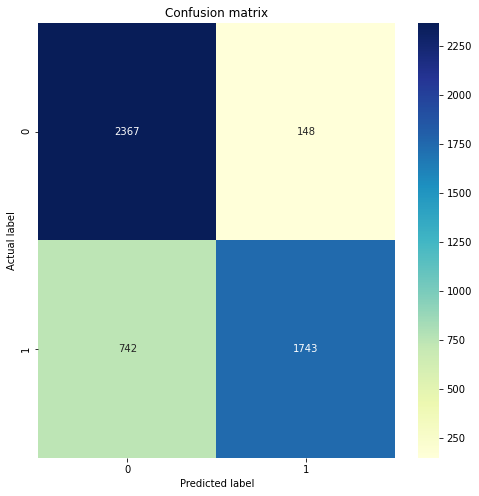

In [17]:
# function that returns the label for a given probability
def getLabel(prob):
    if(prob > .5):
               return 'dog'
    else:
               return 'cat'

# get the predictions for the validation data
val_df = validate_df.copy()
val_df['pred'] = ""
val_pred_prob = model.predict(validation_generator)

for i in range(val_pred_prob.shape[0]):
    val_df['pred'][i] = getLabel(val_pred_prob[i])
          
# create a confusion matrix
y_val = val_df['category']
y_pred = val_df['pred']

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))
cnf_matrix = confusion_matrix(y_val, y_pred)

# plot the confusion matrix in form of a heatmap

%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(8, 8))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Step #9 Make Predictions on Sample Images

Found 46 validated image filenames belonging to 2 classes.
Accuracy: 0.76


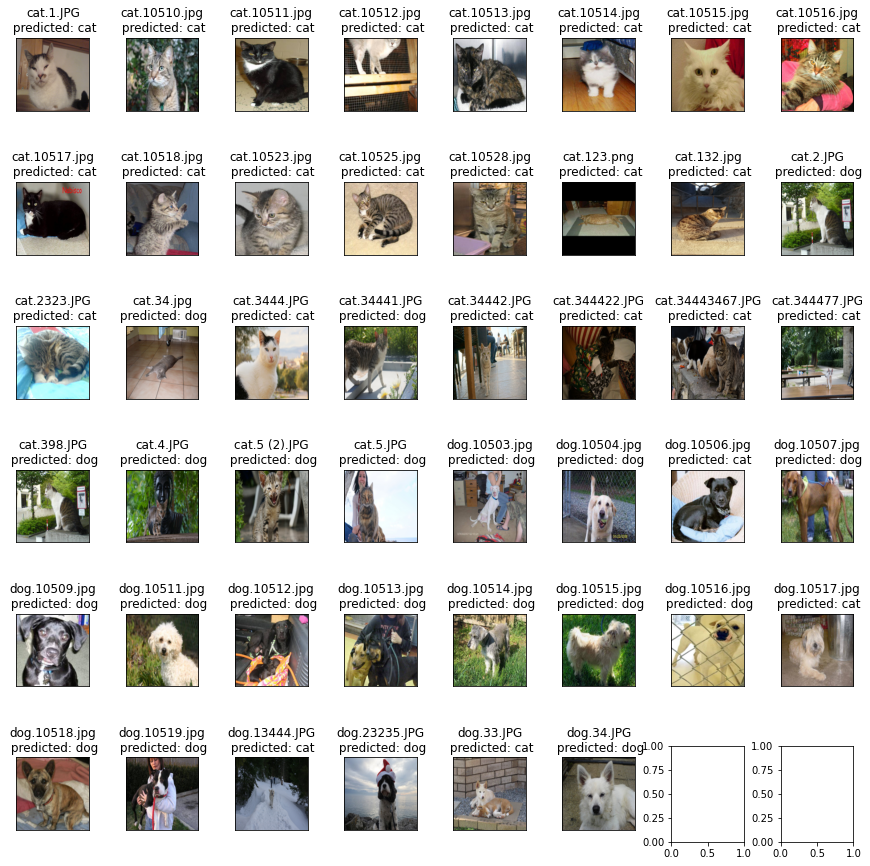

In [21]:
# set the path to the sample images
sample_path = "data/cats-and-dogs/sample/"
sample_df = createImageDf(sample_path)
sample_df['category'] = sample_df['category'].replace({0:'cat',1:'dog'})
sample_df['pred'] = ""

# create an image data generator for the sample images - we will only rescale the images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    sample_df, 
    sample_path,    
    shuffle=False,
    x_col='filename', y_col='category',
    target_size=target_size)

# make the predictions 
pred_prob = model.predict(test_generator)
image_number = pred_prob.shape[0]

# define the plot size
nrows = 6
ncols = int(round(image_number / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(pred_prob.shape[0]):
    sample_df['pred'][i] = getLabel(pred_prob[i])
    
print('Accuracy: {:.2f}'.format(accuracy_score(sample_df['category'], sample_df['pred'])))

# print the images
i = 0
for n in range(nrows):
    for c in range(ncols):
        if i < image_number:
            filepath = sample_path + sample_df.at[i ,'filename']
            img = Image.open(filepath).resize(target_size)
            plt.sca(ax[n, c])
            #plt.tick_params(axis = 'None')
            plt.xticks([]); plt.yticks([])
            plt.title(sample_df.at[i ,'filename'] + '\n' + ' predicted: '  + str(sample_df.at[i ,'pred']))
            plt.imshow(img)
            i += 1